In [14]:
try:
    import sklearn
    print(sklearn.__version__)
    if (sklearn.__version__ < '1.5.2'): #update for latest scikit-learn version
        !pip install -U --user scikit-learn
except Exception as e:
    !pip install scikit-learn

try:
    import geopandas
    print(geopandas.__version__)
except Exception as e:
    !pip install geopandas

1.5.2
1.0.1


In [28]:
import pandas as pd
import statsmodels.api as sm
from scipy.stats import pearsonr

# Read the data files
vap_2021_df = pd.read_csv(r'C:\Users\solrf\OneDrive\Documents\CS216Project\ACSST1Y2021.S2901-Data.csv')
vap_2017_df = pd.read_csv(r'C:\Users\solrf\OneDrive\Documents\CS216Project\ACSST1Y2017.S2901-Data.csv')
election_results_df = pd.read_csv(r'C:\Users\solrf\OneDrive\Documents\CS216Project\state_returns.csv')

# Display the first few rows of each dataset to understand their structure
vap_2021_df_head = vap_2021_df.head()
election_results_df_head = election_results_df.head()

vap_2021_info = vap_2021_df.info()
election_results_df_info = election_results_df.info()

vap_2021_df_head, election_results_df_head, vap_2021_info, election_results_df_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Columns: 119 entries, Geography to Unnamed: 118
dtypes: float64(43), int64(48), object(28)
memory usage: 48.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4287 entries, 0 to 4286
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              4287 non-null   int64  
 1   state             4287 non-null   object 
 2   state_po          4287 non-null   object 
 3   state_fips        4287 non-null   int64  
 4   state_cen         4287 non-null   int64  
 5   state_ic          4287 non-null   int64  
 6   office            4287 non-null   object 
 7   candidate         4000 non-null   object 
 8   party_detailed    3831 non-null   object 
 9   writein           4284 non-null   object 
 10  candidatevotes    4287 non-null   int64  
 11  totalvotes        4287 non-null   int64  
 12  version           4287 non-null   int64  
 13 

(     Geography Geographic Area Name  \
 0  0400000US01              Alabama   
 1  0400000US02               Alaska   
 2  0400000US04              Arizona   
 3  0400000US05             Arkansas   
 4  0400000US06           California   
 
    Estimate!!Total!!Citizens 18 years and over  \
 0                                      3829788   
 1                                       533852   
 2                                      5216518   
 3                                      2237649   
 4                                     26028290   
 
    Margin of Error!!Total!!Citizens 18 years and over  \
 0                                               6729    
 1                                               2824    
 2                                              14241    
 3                                               6177    
 4                                              39993    
 
    Estimate!!Total!!Citizens 18 years and over!!AGE!!18 to 29 years  \
 0                          

Election Results Data Wrangling

In [16]:
# Group the data by year, state, and party_simplified, then sum the candidatevotes for each group
grouped_df = election_results_df.groupby(['year', 'state', 'party_simplified'], as_index=False)['candidatevotes'].sum()

# Pivot the data to have one row per year-state and columns for each party
pivot_df = grouped_df.pivot(index=['year', 'state'], columns='party_simplified', values='candidatevotes').reset_index()

# Fill NaN values with 0 (indicating no votes for that party in that year-state)
pivot_df = pivot_df.fillna(0)

# Combine 'LIBERTARIAN' votes into 'Other_votes' if LIBERTARIAN exists
if 'LIBERTARIAN' in pivot_df.columns:
    pivot_df['OTHER'] = pivot_df.get('OTHER', 0) + pivot_df['LIBERTARIAN']

# Drop the 'LIBERTARIAN' column if it exists
pivot_df = pivot_df.drop(columns=['LIBERTARIAN'], errors='ignore')

# Rename columns for clarity
pivot_df.rename(columns={
    'DEMOCRAT': 'Democrat_votes',
    'REPUBLICAN': 'Republican_votes',
    'OTHER': 'Other_votes'
}, inplace=True)

elec_results_agg = pivot_df
elec_results_agg

party_simplified,year,state,Democrat_votes,Other_votes,Republican_votes
0,1976,ALABAMA,659170.0,19610.0,504070.0
1,1976,ALASKA,44058.0,7961.0,71555.0
2,1976,ARIZONA,295602.0,28475.0,418642.0
3,1976,ARKANSAS,498604.0,1028.0,267903.0
4,1976,CALIFORNIA,3742284.0,179242.0,3882244.0
...,...,...,...,...,...
607,2020,VIRGINIA,2413568.0,84526.0,1962430.0
608,2020,WASHINGTON,2369612.0,133368.0,1584651.0
609,2020,WEST VIRGINIA,235984.0,13286.0,545382.0
610,2020,WISCONSIN,1630866.0,56991.0,1610184.0


In [17]:
# Create a new table for just 2016 election results
elec_results_2016 = elec_results_agg[elec_results_agg['year'] == 2016]

elec_results_2016['state_lower'] = elec_results_2016['state'].str.lower()
vap_2017_df['geographic_area_lower'] = vap_2017_df['Geographic Area Name'].str.lower()

# Perform the merge using the normalized columns
elec_results_2016 = elec_results_2016.merge(
    vap_2017_df,
    how='left',
    left_on='state_lower',
    right_on='geographic_area_lower'
)

# Drop the temporary lowercase columns if not needed
elec_results_2016 = elec_results_2016.drop(columns=['state_lower', 'geographic_area_lower'])

# Display the result
elec_results_2016

C:\Users\solrf\AppData\Local\Temp\ipykernel_6372\730077607.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elec_results_2016['state_lower'] = elec_results_2016['state'].str.lower()


,year,state,Democrat_votes,Other_votes,Republican_votes,Geography,Geographic Area Name,Total!!Estimate!!Citizens 18 years and over,Total!!Margin of Error!!Citizens 18 years and over,Percent!!Estimate!!Citizens 18 years and over,...,Percent!!Margin of Error!!POVERTY STATUS!!Income in the past 12 months below poverty level,Total!!Estimate!!POVERTY STATUS!!Income in the past 12 months at or above the poverty level,Total!!Margin of Error!!POVERTY STATUS!!Income in the past 12 months at or above the poverty level,Percent!!Estimate!!POVERTY STATUS!!Income in the past 12 months at or above the poverty level,Percent!!Margin of Error!!POVERTY STATUS!!Income in the past 12 months at or above the poverty level,"Total!!Estimate!!HOUSEHOLD INCOME (IN 2017 INFLATION-ADJUSTED DOLLARS)!!Median Household Income for Households with a Citizen, Voting-Age Householder","Total!!Margin of Error!!HOUSEHOLD INCOME (IN 2017 INFLATION-ADJUSTED DOLLARS)!!Median Household Income for Households with a Citizen, Voting-Age Householder","Percent!!Estimate!!HOUSEHOLD INCOME (IN 2017 INFLATION-ADJUSTED DOLLARS)!!Median Household Income for Households with a Citizen, Voting-Age Householder","Percent!!Margin of Error!!HOUSEHOLD INCOME (IN 2017 INFLATION-ADJUSTED DOLLARS)!!Median Household Income for Households with a Citizen, Voting-Age Householder",Unnamed: 118
0,2016,ALABAMA,729547.0,75570.0,1318255.0,0400000US01,Alabama,3688249,5643,(X),...,0.5,3072623,16958,85.7,0.5,48452,772,(X),(X),NaN
1,2016,ALASKA,116454.0,38767.0,163387.0,0400000US02,Alaska,531653,3005,(X),...,0.7,468598,4449,90.5,0.7,74048,2864,(X),(X),NaN
2,2016,ARIZONA,1161209.0,159555.0,1252401.0,0400000US04,Arizona,4895706,14005,(X),...,0.3,4201933,20643,87.9,0.3,58252,656,(X),(X),NaN
3,2016,ARKANSAS,380494.0,65269.0,684872.0,0400000US05,Arkansas,2207894,4945,(X),...,0.5,1825665,11384,85.6,0.5,45947,794,(X),(X),NaN
4,2016,CALIFORNIA,8753788.0,943997.0,4483810.0,0400000US06,California,25650455,39934,(X),...,0.1,22461135,51256,89.5,0.1,76088,331,(X),(X),NaN
5,2016,COLORADO,1338870.0,238866.0,1202484.0,0400000US08,Colorado,4057437,9372,(X),...,0.3,3587879,15327,90.7,0.3,70478,687,(X),(X),NaN
6,2016,CONNECTICUT,897572.0,74133.0,673215.0,0400000US09,Connecticut,2611667,9339,(X),...,0.4,2311644,14314,91.8,0.4,75751,1121,(X),(X),NaN
7,2016,DELAWARE,235603.0,20860.0,185127.0,0400000US10,Delaware,709999,4015,(X),...,0.8,608267,6769,88.4,0.8,63626,2672,(X),(X),NaN
8,2016,DISTRICT OF COLUMBIA,282830.0,17022.0,12723.0,0400000US11,District of Columbia,510514,4960,(X),...,1.1,410086,6290,85.4,1.1,82468,2884,(X),(X),NaN
9,2016,FLORIDA,4504975.0,297178.0,4617886.0,0400000US12,Florida,15014950,31938,(X),...,0.2,13002285,40779,88.6,0.2,54216,392,(X),(X),NaN


Add a new Voter Turnout by Percentage Column

In [18]:
# Step 1: Create a 'Total_votes' column by summing up the party vote counts
elec_results_2016['Total_votes'] = (
    elec_results_2016['Democrat_votes'] +
    elec_results_2016['Republican_votes'] +
    elec_results_2016['Other_votes']
)

# Step 2: Calculate voter turnout percentage
# Ensure the population column exists and is not null
population_col = "Total!!Estimate!!Citizens 18 years and over"
if population_col in elec_results_2016.columns:
    elec_results_2016['Voter_turnout_percentage'] = (
        elec_results_2016['Total_votes'] / elec_results_2016[population_col] * 100
    ).round(2)  # Rounded to 2 decimal places for readability

# Step 3: Rename the population column for clarity
elec_results_2016.rename(columns={population_col: 'Voting_Age_Population'}, inplace=True)


In [19]:
columns_to_select = ['year', 'state', 'Total_votes', 'Voter_turnout_percentage']
selected_df = elec_results_2016[columns_to_select]
selected_df

,year,state,Total_votes,Voter_turnout_percentage
0,2016,ALABAMA,2123372.0,57.57
1,2016,ALASKA,318608.0,59.93
2,2016,ARIZONA,2573165.0,52.56
3,2016,ARKANSAS,1130635.0,51.21
4,2016,CALIFORNIA,14181595.0,55.29
5,2016,COLORADO,2780220.0,68.52
6,2016,CONNECTICUT,1644920.0,62.98
7,2016,DELAWARE,441590.0,62.20
8,2016,DISTRICT OF COLUMBIA,312575.0,61.23
9,2016,FLORIDA,9420039.0,62.74


In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
import json
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

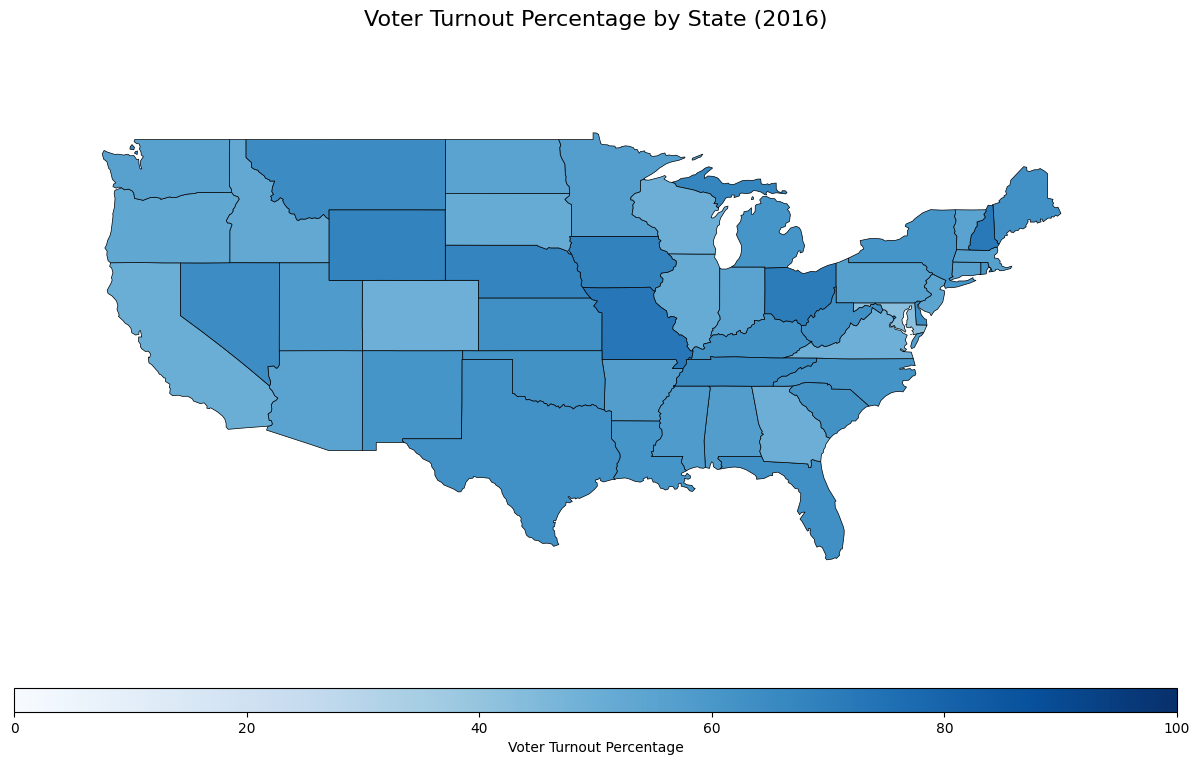

In [21]:


# Step 1: Load U.S. GeoJSON file (replace with your path or download URL)
geojson_file = r'C:\Users\solrf\OneDrive\Documents\CS216Project\us-states.json'  # Replace this with your local GeoJSON path
with open(geojson_file) as f:
    geojson_data = json.load(f)

# Step 2: Prepare state geometries
state_geometries = {feature['properties']['name']: feature['geometry'] for feature in geojson_data['features']}

# Step 3: Prepare your voter turnout data
state_turnout = elec_results_2016.set_index('state')['Voter_turnout_percentage'].to_dict()

# Step 4: Normalize voter turnout data for color mapping
cmap = cm.Blues
norm = colors.Normalize(vmin=0, vmax=100)

# Step 5: Plot the U.S. map
fig, ax = plt.subplots(figsize=(15, 10))
patches = []
state_colors = []

# Normalize state names in both datasets
geojson_state_names = {feature['properties']['name'].lower(): feature['geometry'] for feature in geojson_data['features']}
state_turnout_lower = {state.lower(): turnout for state, turnout in state_turnout.items()}

# Loop through and map colors
for state_name, geometry in geojson_state_names.items():
    turnout = state_turnout_lower.get(state_name, None)  # None for missing states
    if turnout is not None:
        state_colors.append(cmap(norm(turnout)))
    else:
        state_colors.append('lightgrey')  # Default color for missing data

    if geometry['type'] == 'Polygon':
        coords = geometry['coordinates']
        for polygon in coords:
            patches.append(Polygon(polygon))
    elif geometry['type'] == 'MultiPolygon':
        for multipolygon in geometry['coordinates']:
            for polygon in multipolygon:
                patches.append(Polygon(polygon))


# Add patches to the map
collection = PatchCollection(patches, facecolor=state_colors, edgecolor='black', linewidth=0.5, match_original=True)
ax.add_collection(collection)

# Add legend
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05, aspect=50)
cbar.set_label('Voter Turnout Percentage')

# Final touches
ax.set_title('Voter Turnout Percentage by State (2016)', fontsize=16)
ax.set_xlim([-130, -60])  # Adjust longitude limits
ax.set_ylim([20, 55])     # Adjust latitude limits
ax.axis('off')  # Hide axes for clarity

plt.show()


Prep for Models

We need to create new brackets, for median income, age, and educational levels

In [22]:
elec_results_2016_regression = elec_results_2016

# add total votes and voter turnout percentage columns
elec_results_2016_regression['Total_votes'] = elec_results_2016_regression['Democrat_votes'] + elec_results_2016_regression['Republican_votes'] + elec_results_2016_regression['Other_votes']
elec_results_2016_regression['Voter_turnout_percentage'] = (elec_results_2016_regression['Total_votes'] / elec_results_2016_regression['Voting_Age_Population'] * 100).round(2)

# keep this column Total!!Estimate!!HOUSEHOLD INCOME (IN 2017 INFLATION-ADJUSTED DOLLARS)!!Median Household Income for Households with a Citizen, Voting-Age Householder but rename it to something more appropriate
elec_results_2016_regression = elec_results_2016_regression[["Geographic Area Name", "Voter_turnout_percentage","Total_votes", "Total!!Estimate!!HOUSEHOLD INCOME (IN 2017 INFLATION-ADJUSTED DOLLARS)!!Median Household Income for Households with a Citizen, Voting-Age Householder", "Total!!Estimate!!High school degree or higher", "Total!!Estimate!!Bachelor's degree or higher"]]

# Can you rename "Estimate!!Total!!Citizens 18 years and over!!HOUSEHOLD INCOME (IN 2021 INFLATION-ADJUSTED DOLLARS)!!Median Household Income for Households with a Citizen, Voting-Age Householder" to something more appropriate?
elec_results_2016_regression = elec_results_2016_regression.rename(columns={
    "Total!!Estimate!!HOUSEHOLD INCOME (IN 2017 INFLATION-ADJUSTED DOLLARS)!!Median Household Income for Households with a Citizen, Voting-Age Householder": "Median_Household_Income_Citizen_Voting_Age",
    "Total!!Estimate!!High school degree or higher": "High_school_degree_or_higher",
    "Total!!Estimate!!Bachelor's degree or higher": "Bachelor's_degree_or_higher",
})

print(elec_results_2016_regression.head())

  Geographic Area Name  Voter_turnout_percentage  Total_votes  \
0              Alabama                     57.57    2123372.0   
1               Alaska                     59.93     318608.0   
2              Arizona                     52.56    2573165.0   
3             Arkansas                     51.21    1130635.0   
4           California                     55.29   14181595.0   

   Median_Household_Income_Citizen_Voting_Age  High_school_degree_or_higher  \
0                                       48452                       3210220   
1                                       74048                        486606   
2                                       58252                       4379545   
3                                       45947                       1939060   
4                                       76088                      22810158   

   Bachelor's_degree_or_higher  
0                       855938  
1                       137396  
2                      1348026  
3 

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

X = elec_results_2016_regression[['Total_votes', 'Median_Household_Income_Citizen_Voting_Age', 
          'High_school_degree_or_higher', "Bachelor's_degree_or_higher"]]
y = elec_results_2016_regression['Voter_turnout_percentage']

# Number of bootstrap samples
n_bootstraps = 1000

# Dictionary to store bootstrap R-squared values for each feature
bootstrap_r2 = {feature: [] for feature in X.columns}

# Perform bootstrapping
for _ in range(n_bootstraps):
    # Resample the dataset with replacement
    resampled_indices = np.random.choice(range(len(X)), size=len(X), replace=True)
    X_resampled = X.iloc[resampled_indices]
    y_resampled = y.iloc[resampled_indices]
    
    # Calculate R-squared for each feature
    for feature in X.columns:
        X_single = X_resampled[[feature]].values
        X_train_single, X_test_single, y_train, y_test = train_test_split(
            X_single, y_resampled, test_size=0.3
        )
        model_single = LinearRegression()
        model_single.fit(X_train_single, y_train)
        y_pred_single = model_single.predict(X_test_single)
        r2 = r2_score(y_test, y_pred_single)
        bootstrap_r2[feature].append(r2)

# Calculate mean and confidence intervals for each feature's R-squared values
bootstrap_results = {
    feature: {
        "mean_r2": np.mean(r2_values),
        "95%_CI": (np.percentile(r2_values, 5), np.percentile(r2_values, 95))
    }
    for feature, r2_values in bootstrap_r2.items()
}

# Display the bootstrap results
bootstrap_results

{'Total_votes': {'mean_r2': -0.16770452207677358,
  '95%_CI': (-0.6585249233174012, 0.048641630500760716)},
 'Median_Household_Income_Citizen_Voting_Age': {'mean_r2': -0.026162042088500797,
  '95%_CI': (-0.5478073844938578, 0.3471743009782031)},
 'High_school_degree_or_higher': {'mean_r2': -0.16227303966478698,
  '95%_CI': (-0.6427738922952103, 0.060881328893779875)},
 "Bachelor's_degree_or_higher": {'mean_r2': -0.18062247862197972,
  '95%_CI': (-0.7141645618464171, 0.04803077566218237)}}

As we can see, we see that many factors such as education and household income don't affect voter turn out.

Investigating if states with higer voter turnout tend to have have median income

Election Summary DataFrame:
         state  Total_votes
0     Alabama      2123372
1      Alaska       318608
2     Arizona      2573165
3    Arkansas      1130635
4  California     14181595
VAP Income DataFrame:
         state  Median_Household_Income
0     Alabama                    48452
1      Alaska                    74048
2     Arizona                    58252
3    Arkansas                    45947
4  California                    76088
Merged DataFrame:
         state  Total_votes  Median_Household_Income
0     Alabama      2123372                    48452
1      Alaska       318608                    74048
2     Arizona      2573165                    58252
3    Arkansas      1130635                    45947
4  California     14181595                    76088
Correlation between Total Votes and Median Household Income: 0.13796260987498055
P-value for the correlation: 0.33431864584638127


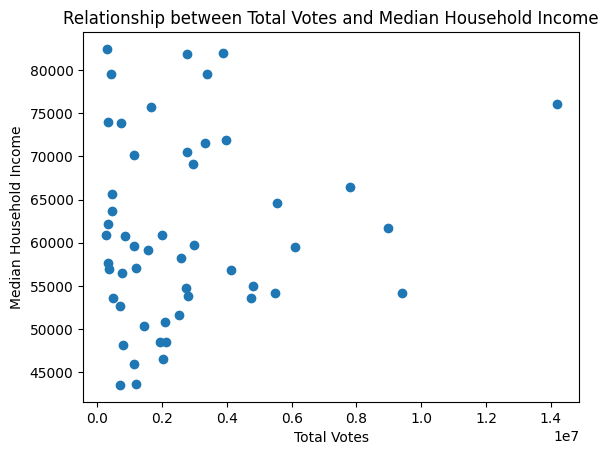

In [33]:

# Step 1: Aggregate election results by state to calculate total votes
election_summary = election_results_df[election_results_df['year'] == 2016]
election_summary = election_summary.groupby('state', as_index=False)['candidatevotes'].sum()
election_summary.rename(columns={'candidatevotes': 'Total_votes'}, inplace=True)

# Standardize state names to title case
election_summary['state'] = election_summary['state'].str.title()

# Check the contents of election_summary
print("Election Summary DataFrame:\n", election_summary.head())

# Step 2: Extract median household income data from VAP dataset
# Adjust the income column name based on the dataset
vap_2017_df.rename(columns={
    'Geographic Area Name': 'state', 
    'Total!!Estimate!!HOUSEHOLD INCOME (IN 2017 INFLATION-ADJUSTED DOLLARS)!!Median Household Income for Households with a Citizen, Voting-Age Householder': 'Median_Household_Income'
}, inplace=True)

# Filter out rows with missing income data
vap_income_df = vap_2017_df[['state', 'Median_Household_Income']].dropna()

# Standardize state names to title case in the VAP dataset as well
vap_income_df['state'] = vap_income_df['state'].str.title()

# Check the contents of vap_income_df
print("VAP Income DataFrame:\n", vap_income_df.head())

# Step 3: Merge election summary with VAP income data by state
merged_df = election_summary.merge(vap_income_df, on='state')

# Check the contents of merged_df
print("Merged DataFrame:\n", merged_df.head())

# Ensure merged_df has enough data for correlation analysis
if len(merged_df) >= 2:
    # Step 4: Analyze correlation between total votes (proxy for turnout) and median household income
    correlation, p_value = pearsonr(merged_df['Total_votes'], merged_df['Median_Household_Income'])

    print("Correlation between Total Votes and Median Household Income:", correlation)
    print("P-value for the correlation:", p_value)

    # Optional: Scatter plot for visual analysis
    plt.scatter(merged_df['Total_votes'], merged_df['Median_Household_Income'])
    plt.xlabel('Total Votes')
    plt.ylabel('Median Household Income')
    plt.title('Relationship between Total Votes and Median Household Income')
    plt.show()
else:
    print("Not enough data for correlation analysis. Check the merging process and input data.")


Upon inspection of the results, it appears that there is a weak positive correlation between total votes and median household income.

                            OLS Regression Results                            
Dep. Variable:     Turnout_Percentage   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9507
Date:                Fri, 08 Nov 2024   Prob (F-statistic):              0.334
Time:                        21:36:01   Log-Likelihood:                -222.65
No. Observations:                  51   AIC:                             449.3
Df Residuals:                      49   BIC:                             453.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

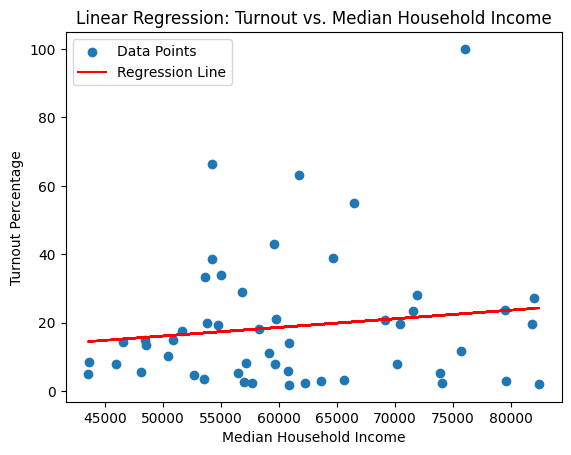

In [34]:
election_summary = election_results_df[election_results_df['year'] == 2016]
election_summary = election_summary.groupby('state', as_index=False)['candidatevotes'].sum()
election_summary.rename(columns={'candidatevotes': 'Total_votes'}, inplace=True)

# Standardize state names to title case
election_summary['state'] = election_summary['state'].str.title()

# Step 2: Extract median household income data from VAP dataset
vap_2017_df.rename(columns={
    'Geographic Area Name': 'state', 
    'Total!!Estimate!!HOUSEHOLD INCOME (IN 2017 INFLATION-ADJUSTED DOLLARS)!!Median Household Income for Households with a Citizen, Voting-Age Householder': 'Median_Household_Income'
}, inplace=True)

# Filter out rows with missing income data
vap_income_df = vap_2017_df[['state', 'Median_Household_Income']].dropna()

# Standardize state names to title case in the VAP dataset as well
vap_income_df['state'] = vap_income_df['state'].str.title()

# Step 3: Merge election summary with VAP income data by state
merged_df = election_summary.merge(vap_income_df, on='state')

# Calculate voter turnout as a percentage of total votes (proxy for turnout)
# Note: If turnout percentage data is directly available, use it instead
# For demonstration, I’ll assume turnout is calculated using Total_votes / max(Total_votes) * 100 to normalize.
merged_df['Turnout_Percentage'] = (merged_df['Total_votes'] / merged_df['Total_votes'].max()) * 100

# Step 4: Set up and run linear regression with median household income as predictor
X = merged_df['Median_Household_Income']
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = merged_df['Turnout_Percentage']

model = sm.OLS(y, X).fit()  # Fit the model
predictions = model.predict(X)  # Make predictions

# Display the summary of regression results
print(model.summary())

# Plot the regression line
plt.scatter(merged_df['Median_Household_Income'], merged_df['Turnout_Percentage'], label='Data Points')
plt.plot(merged_df['Median_Household_Income'], predictions, color='red', label='Regression Line')
plt.xlabel('Median Household Income')
plt.ylabel('Turnout Percentage')
plt.title('Linear Regression: Turnout vs. Median Household Income')
plt.legend()
plt.show()
